## This nb borrowed lines from fastai, OpenAI & ChatGPT

In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel
import torchvision.transforms.functional as TF,torch.nn.functional as F

In [2]:
import fastcore.all as fc
from miniai.datasets import *
from miniai.training import *

from datasets import load_dataset,load_dataset_builder

In [3]:
from huggingface_hub import hf_hub_download
import json 

In [4]:
class SomeException(BaseException):
    pass
    
try:
    if torch.cuda.is_available():
        print('# of GPUs available = ', torch.cuda.device_count())
    else:
        raise SomeException
except SomeException:
    print("ERROR: GPU is missing")

# of GPUs available =  1


### Loading Tiny-Imagenet

In [5]:
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name)

In [6]:
@inplace
def transformi(b):
    b[xl] = b[xl]

bs = 32
#hg_tds = dsd.with_transform(transformi)
#dls = DataLoaders.from_dd(hg_tds, bs, num_workers=7)
hg_tds = dsd

#### ori is above, new is below

In [7]:
class TinyHFDS:
    # this is specific for Hugging Face's dsd which can be very slow to index
    def __init__(self, hg_ds):
        self.ds = hg_ds
        # the 2 lines below must be done here because the execution of "ds['train']['image']" takes 18seconds
        # once it has executed, indexing it is very fast (5 milliseconds)
        self.image = hg_ds['image']
        self.label = hg_ds['label']
    def __len__(self): return self.ds.num_rows
    def __getitem__(self, i): return TF.to_tensor(self.image[i]), self.label[i]

In [8]:
tds = TinyHFDS(hg_tds['train'])

In [9]:
vds = TinyHFDS(hg_tds['valid'])

In [10]:
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return self.tfmx(x),self.tfmy(y)

### TODO: Add normalisation to datasets, see Jeremy's nb_24

In [117]:
def tfmx(x):
    try:
        if len(x.shape) == 3 and x.shape[0] == 3:
            pass
        else:
            x = torch.ones([3,1,1]) * x
    except SomeException:
        print("ERROR: x doesn't have 3 channels")
    return x

In [118]:
def tfmy(y): 
    return y

In [119]:
tfm_tds = TfmDS(tds, tfmx, tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [120]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=7))

In [127]:
dt = dls.train
xb,yb = next(iter(dt))

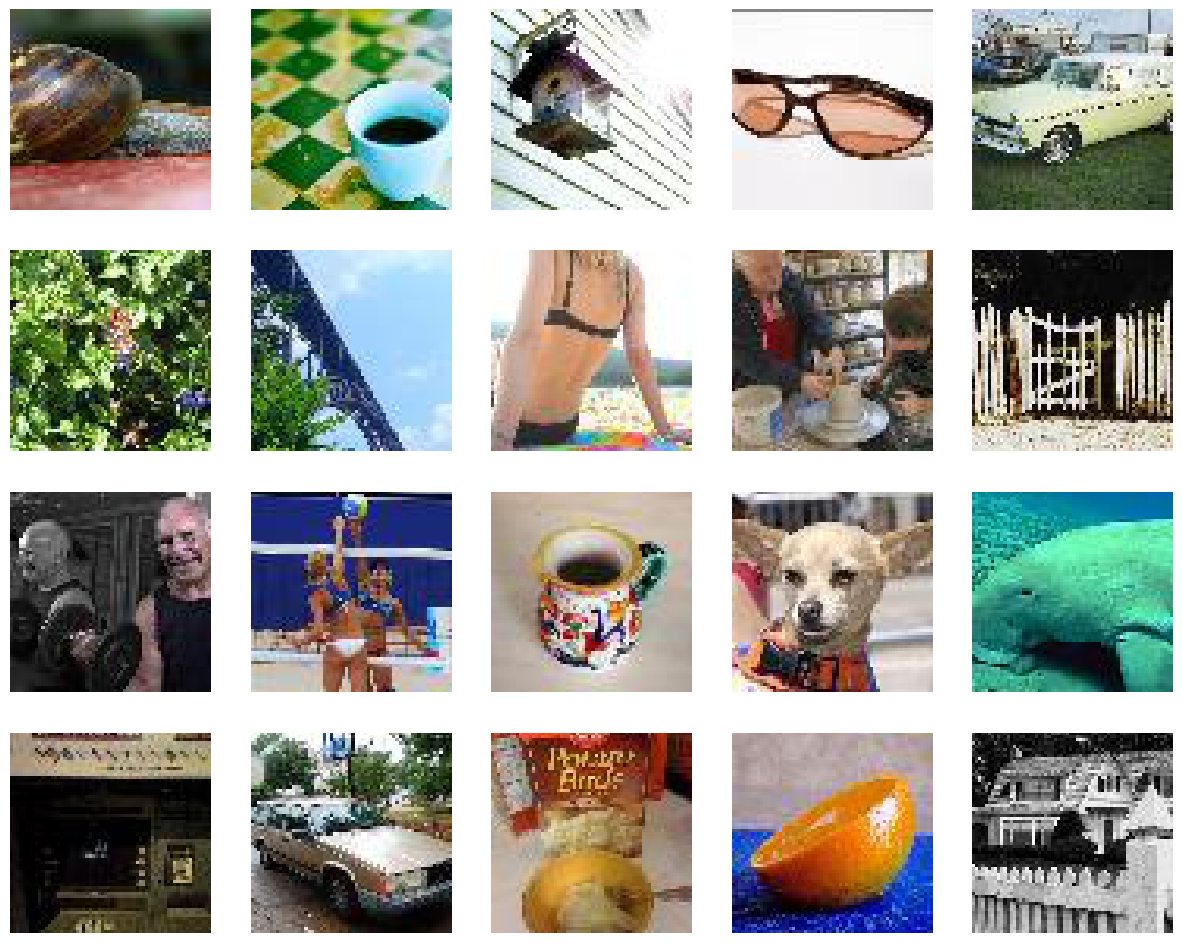

In [128]:
show_images(xb[0:20])

In [129]:
xb,yb = next(iter(dt))

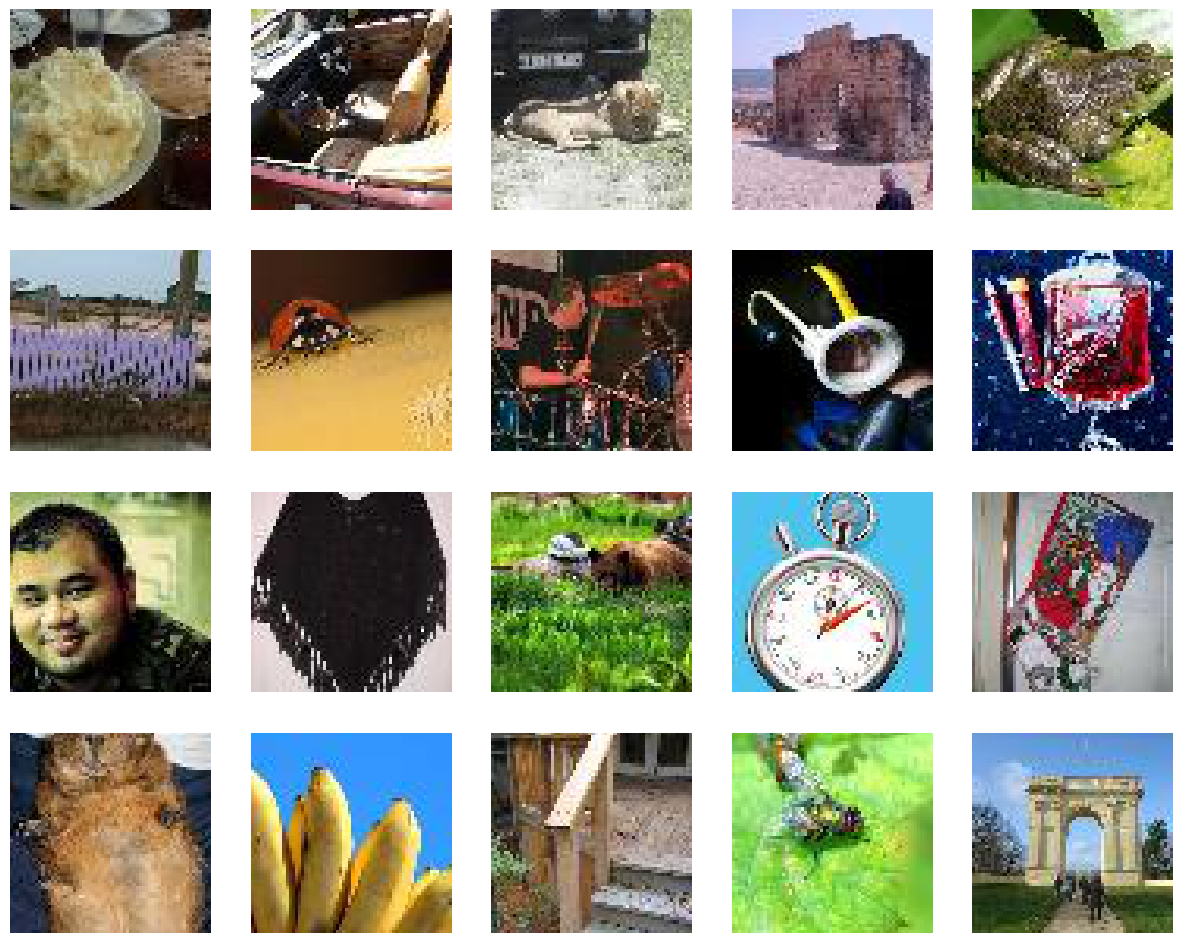

In [130]:
show_images(xb[0:20])

### BROKEN: Generate captions for CLIP to use

In [ ]:
# load the files
fp_json_pos2idx = hf_hub_download(repo_id=name, filename="dataset_infos.json", repo_type="dataset")
fp_idx2human = hf_hub_download(repo_id=name, filename="classes.py", repo_type="dataset")

In [ ]:
f = open(fp_json_pos2idx,) 
data_pos2idx = json.load(f) 
f.close() 

In [ ]:
# Repo provided a variable called 'i2d'
exec(open(fp_idx2human).read()) 
# Let's rename this variable to something suitable for this notebook
idx2human = i2d

In [ ]:
pos2idx = data_pos2idx['Maysee--tiny-imagenet']['features']['label']['names']

In [ ]:
pos2human = [idx2human[v] for k,v in enumerate(pos2idx)]

In [ ]:
pos2human[0:5]

In [ ]:
captions = ["A photo of a " + txt.split(",")[0] for txt in pos2human]

In [ ]:
captions[0:5]

In [ ]:
len(captions)

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)

In [ ]:
show_images(xb[0:15])

### Randomly choose an image to pass to CLIP

In [ ]:
pos=(torch.rand(1)*15).round().int().item()
selected_image = xb[pos]

"do_rescale=False" is required for the next cell.
CLIP's predictions are worse by a big margin if input image is rescaled a second time. 


In [ ]:
inputs = processor(text=captions, images=selected_image, return_tensors="pt", padding=True, do_rescale=False)
image_input = inputs["pixel_values"].to("cuda")
text_inputs = inputs["input_ids"].to("cuda")
attention_mask = inputs["attention_mask"].to("cuda")

In [ ]:
show_image(selected_image)

### CLIP: (img, text) -> (img_emb, text_emb)

In [ ]:
with torch.no_grad():
    # Compute the image and text embeddings
    image_features = model.get_image_features(image_input)
    text_features = model.get_text_features(input_ids=text_inputs, attention_mask=attention_mask)

In [ ]:
image_features.shape, text_features.shape

In [ ]:
# Normalize the features
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

### CLIP: dot product and find best 5 matches

In [ ]:
# Compute similarity scores
similarity_scores = image_features @ text_features.T

# Get the index of the best matching text description
best_match_index = similarity_scores.argmax().item()

# Output the best matching text description
print(f"Best match: {captions[best_match_index]} (score: {similarity_scores[0, best_match_index]:.4f})")

In [ ]:
vals, indx = similarity_scores[0].topk(5)
print("\nTop predictions:\n")
for value, index in zip(vals, indx):
    print(f"{captions[index]:>16s}: {100 * value.item():.2f}%")

### True label

In [ ]:
captions[yb[pos]]